- https://github.com/google/Xee
- https://medium.com/google-earth/python-powers-up-the-rise-of-the-python-api-for-earth-engine-056741eb1b75

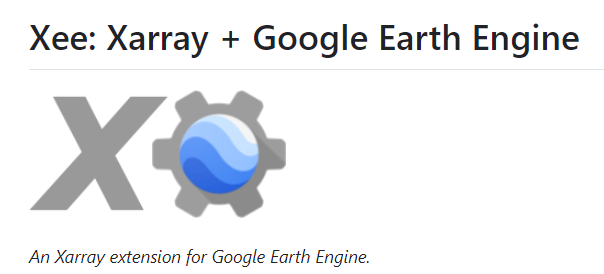

# Instalando Xee e inicializando GEE

In [14]:
# instalando Xee
!pip install -q xee

# importa bibliotecas
import ee, geemap, time
import xarray as xr
import matplotlib.pyplot as plt

# inicializando pelo GEE
ee.Authenticate()
ee.Initialize(project='ee-enrique', opt_url='https://earthengine-highvolume.googleapis.com')

# ou inicializando pelo GEEMAP
#geemap.ee_initialize()

# Carregando os dados do ERA5 mensal
 - https://developers.google.com/earth-engine/datasets/catalog/ECMWF_ERA5_LAND_MONTHLY_AGGR?hl=pt-br

In [2]:
%%time
# carrega dados ERA5 mensais
era5 = ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR').filterDate('2000-01-01','2025-04-01')

# converter para Dataset do Xarray
ds = xr.open_dataset(era5, engine='ee', crs='EPSG:4326', scale=0.25)

# mostrando os dados
ds

CPU times: user 798 ms, sys: 134 ms, total: 931 ms
Wall time: 3 s


<xarray.Dataset> Size: 188GB
Dimensions:                                                    (time: 302,
                                                                lon: 1440,
                                                                lat: 720)
Coordinates:
  * time                                                       (time) datetime64[ns] 2kB ...
  * lon                                                        (lon) float64 12kB ...
  * lat                                                        (lat) float64 6kB ...
Data variables: (12/150)
    dewpoint_temperature_2m                                    (time, lon, lat) float32 1GB ...
    temperature_2m                                             (time, lon, lat) float32 1GB ...
    skin_temperature                                           (time, lon, lat) float32 1GB ...
    soil_temperature_level_1                                   (time, lon, lat) float32 1GB ...
    soil_temperature_level_2                                   (time, lon, lat) float32 1GB ...
    soil_temperature_level_3                                   (time, lon, lat) float32 1GB ...
    ...                                                         ...
    total_precipitation_min                                    (time, lon, lat) float32 1GB ...
    total_precipitation_max                                    (time, lon, lat) float32 1GB ...
    leaf_area_index_high_vegetation_min                        (time, lon, lat) float32 1GB ...
    leaf_area_index_high_vegetation_max                        (time, lon, lat) float32 1GB ...
    leaf_area_index_low_vegetation_min                         (time, lon, lat) float32 1GB ...
    leaf_area_index_low_vegetation_max                         (time, lon, lat) float32 1GB ...
Attributes:
    crs:      EPSG:4326

# Plotando alguns mapas

In [3]:
# mapa interativo com geemap
map = geemap.Map(basemap='SATELLITE')
map

Map(center=[0, 0], controls=(WidgetControl(options=['position', 'transparent_bg'], widget=SearchDataGUI(childr…

In [4]:
# selecionando região de forma interativa no Mapa. Clicar no mapa e depois rodar essa célula de código
#roi = map.draw_last_feature.geometry()
#roi

AttributeError: 'NoneType' object has no attribute 'geometry'

https://www.youtube.com/watch?v=KPgIv_sndTI

In [15]:
%%time

# região de estudo
roi = ee.FeatureCollection('FAO/GAUL/2015/level0').filter(ee.Filter.eq('ADM0_NAME', 'Brazil')) # Em "geometry" usar geometry=roi.geometry()
#roi = ee.FeatureCollection('FAO/GAUL/2015/level1').filter(ee.Filter.eq('ADM1_NAME', 'Sao Paulo')) # Em "geometry" usar geometry=roi.geometry()
#roi = ee.FeatureCollection('FAO/GAUL/2015/level2').filter(ee.Filter.eq('ADM2_NAME', 'Sao Paulo')) # Em "geometry" usar geometry=roi.geometry()
#roi = ee.Geometry.Rectangle([-47.1, -21.1, -44.2, -20.4]) # Em "geometry" usar geometry=roi

# carrega os dados de t2m
t2m_mensal = ee.ImageCollection('ECMWF/ERA5_LAND/MONTHLY_AGGR')\
               .select('temperature_2m')\
               .filterDate('2010-01-01','2024-12-31')\
               .map(lambda img: img.subtract(273.15).copyProperties(img, img.propertyNames()))

# converte para Dataset
ds_t2m_mensal = xr.open_dataset(t2m_mensal,
                                engine = 'ee',
                                crs = 'EPSG:4326',
                                scale = 0.11,
                                geometry = roi.geometry())

# muda de "(time, lon, lat)" para "(time, lat, lon)"
#ds_t2m_mensal = ds_t2m_mensal.transpose("time", "lat", "lon")

# mostrando os dados
ds_t2m_mensal

CPU times: user 95.8 ms, sys: 4.49 ms, total: 100 ms
Wall time: 3.59 s


<xarray.Dataset> Size: 105MB
Dimensions:         (time: 180, lon: 410, lat: 355)
Coordinates:
  * time            (time) datetime64[ns] 1kB 2010-01-01 ... 2024-12-01
  * lon             (lon) float64 3kB -73.93 -73.82 -73.71 ... -29.05 -28.94
  * lat             (lat) float64 3kB -33.7 -33.59 -33.48 ... 5.025 5.135 5.245
Data variables:
    temperature_2m  (time, lon, lat) float32 105MB ...
Attributes:
    crs:      EPSG:4326

In [16]:
# mostra os valores mínimos e máximos de temperatura do dataset mensal
print(ds_t2m_mensal['temperature_2m'].min().values, ds_t2m_mensal['temperature_2m'].max().values)

-21.51000213623047 33.240108489990234


In [17]:
# média anual de temperatura
ds_t2m_anual = ds_t2m_mensal.groupby('time.year').mean('time')
ds_t2m_anual

<xarray.Dataset> Size: 9MB
Dimensions:         (year: 15, lon: 410, lat: 355)
Coordinates:
  * lon             (lon) float64 3kB -73.93 -73.82 -73.71 ... -29.05 -28.94
  * lat             (lat) float64 3kB -33.7 -33.59 -33.48 ... 5.025 5.135 5.245
  * year            (year) int64 120B 2010 2011 2012 2013 ... 2022 2023 2024
Data variables:
    temperature_2m  (year, lon, lat) float32 9MB nan nan nan nan ... nan nan nan
Attributes:
    crs:      EPSG:4326

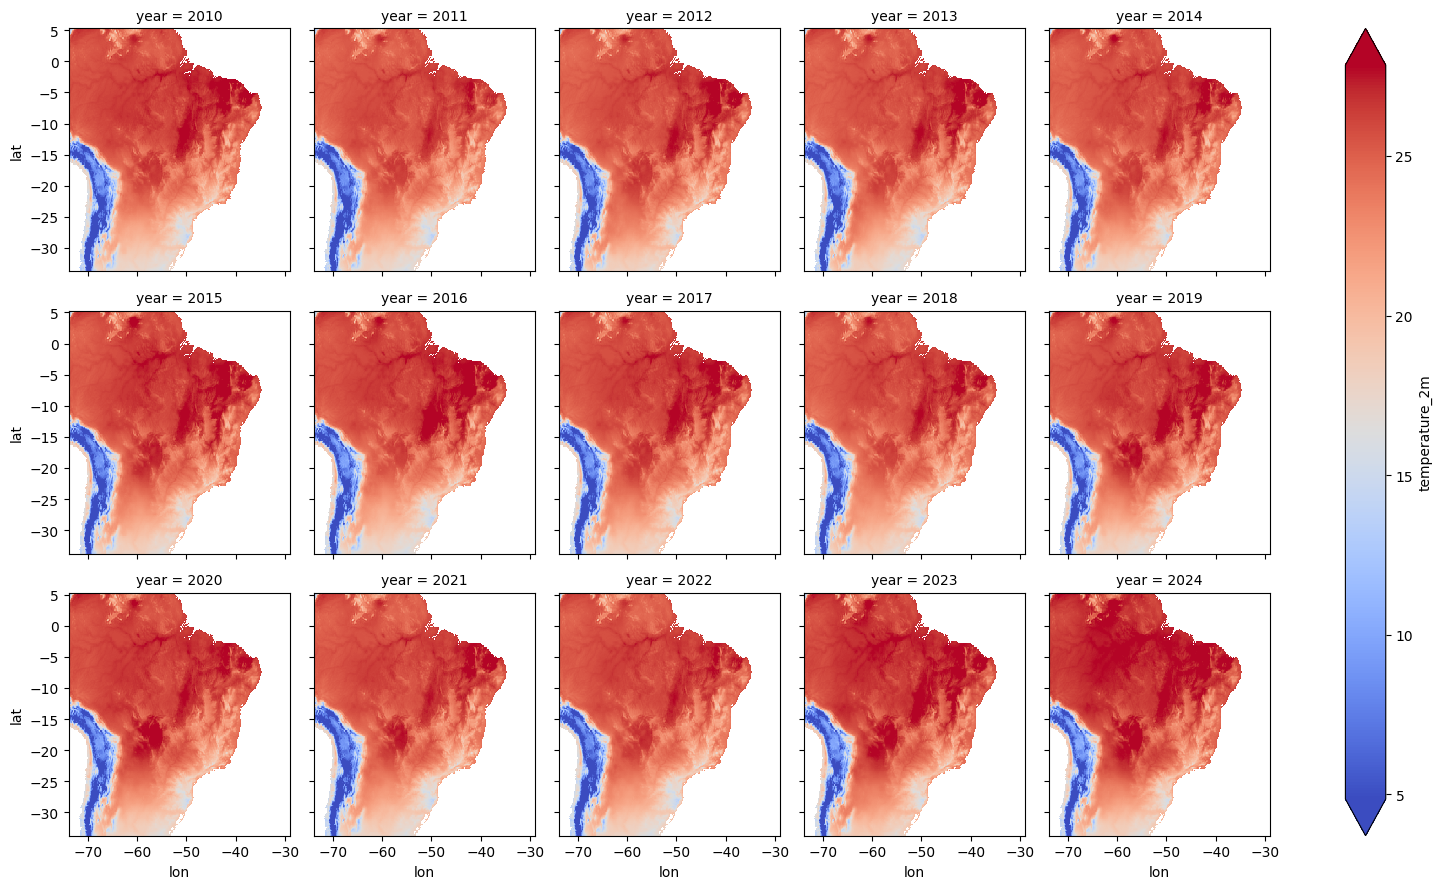

In [22]:
# plota mapa de temperatura média anual
ds_t2m_anual['temperature_2m'].plot(x = 'lon',
                                    y = 'lat',
                                    col = 'year',
                                    robust = True,
                                    col_wrap = 5,
                                    cmap = 'coolwarm')

# salva figura
plt.savefig('temp_anual.png', dpi=300, bbox_inches='tight')

In [23]:
# calcula a anomalia anual
ds_t2m_anual_anomalia = ds_t2m_anual - ds_t2m_anual.mean('year')
ds_t2m_anual_anomalia

<xarray.Dataset> Size: 9MB
Dimensions:         (lon: 410, lat: 355, year: 15)
Coordinates:
  * lon             (lon) float64 3kB -73.93 -73.82 -73.71 ... -29.05 -28.94
  * lat             (lat) float64 3kB -33.7 -33.59 -33.48 ... 5.025 5.135 5.245
  * year            (year) int64 120B 2010 2011 2012 2013 ... 2022 2023 2024
Data variables:
    temperature_2m  (year, lon, lat) float32 9MB nan nan nan nan ... nan nan nan

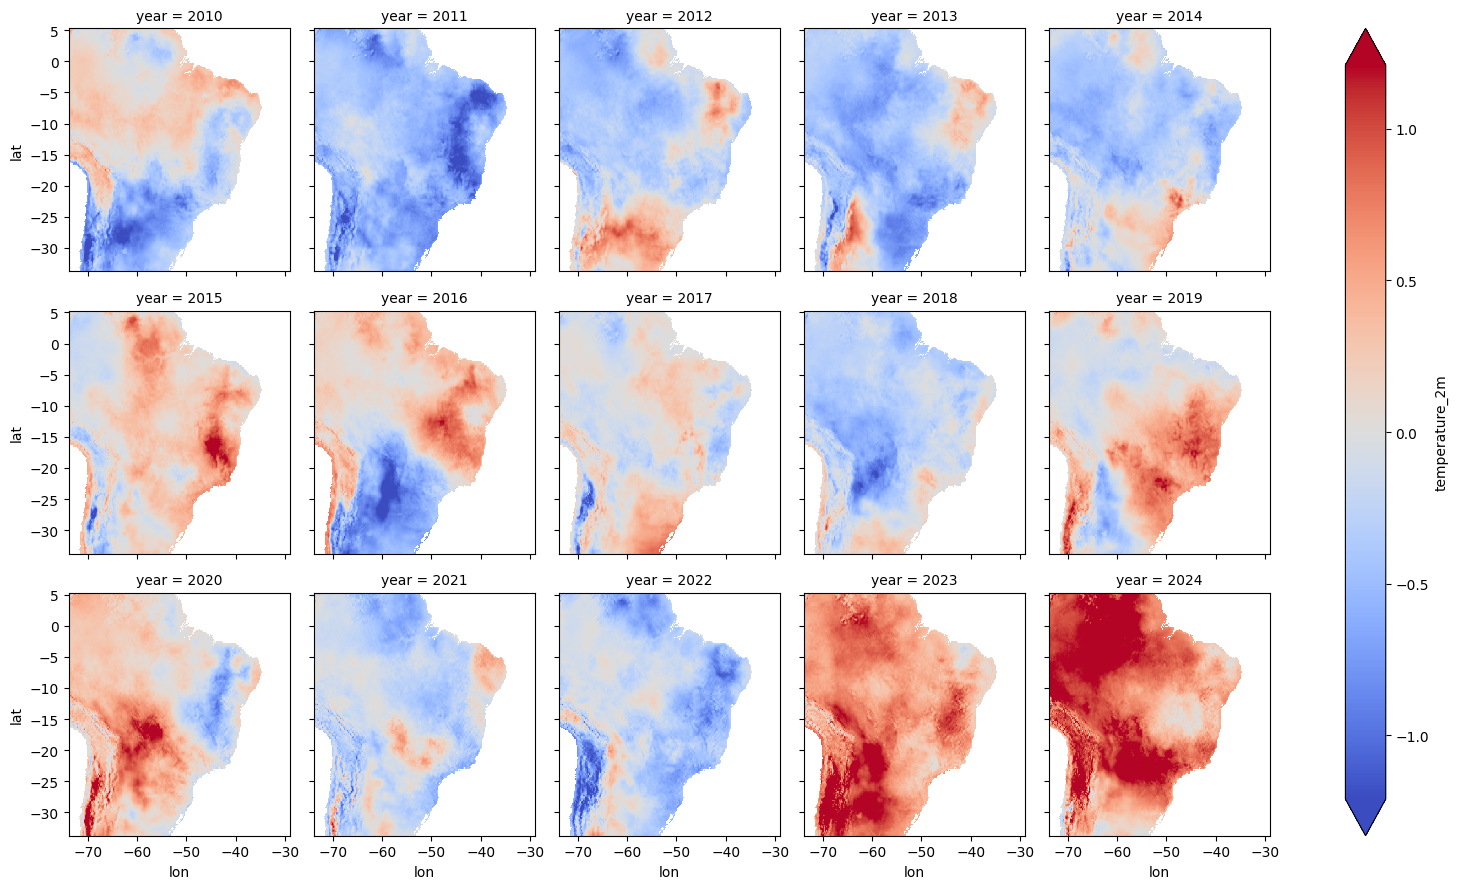

In [24]:
# plota mapa de anomalia média anual
ds_t2m_anual_anomalia['temperature_2m'].plot(x = 'lon',
                                             y = 'lat',
                                             col = 'year',
                                             robust = True,
                                             col_wrap = 5,
                                             cmap = 'coolwarm')

# salva figura
plt.savefig('anom_anual.png', dpi=300, bbox_inches='tight')

In [25]:
# série temporal de temperatura para um ponto (lat, lon)
ds_t2m_anual_sub = ds_t2m_anual.sel(lat=-15.5, lon=-60.2, method='nearest')
ds_t2m_anual_sub

<xarray.Dataset> Size: 196B
Dimensions:         (year: 15)
Coordinates:
    lon             float64 8B -60.18
    lat             float64 8B -15.55
  * year            (year) int64 120B 2010 2011 2012 2013 ... 2022 2023 2024
Data variables:
    temperature_2m  (year) float32 60B 26.21 26.05 26.0 ... 26.32 27.28 27.63
Attributes:
    crs:      EPSG:4326

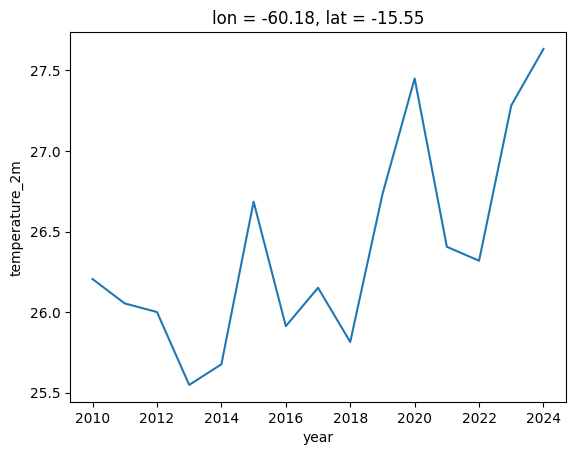

In [26]:
# plota série temporal
ds_t2m_anual_sub['temperature_2m'].plot()

# salva figura
plt.savefig('ts_anual.png', dpi=300, bbox_inches='tight')

In [27]:
# salva arquivos em formato NetCDF
ds_t2m_mensal.to_netcdf('t2m_mensal.nc')
ds_t2m_anual.to_netcdf('t2m_anual.nc')
ds_t2m_anual_anomalia.to_netcdf('anom_anual.nc')

In [28]:
# abre os arquivos NetCDF que foram salvos
ds_t2m_mensal_w = xr.open_dataset('t2m_mensal.nc')
ds_t2m_mensal_w

<xarray.Dataset> Size: 105MB
Dimensions:         (lon: 410, lat: 355, time: 180)
Coordinates:
  * lon             (lon) float64 3kB -73.93 -73.82 -73.71 ... -29.05 -28.94
  * lat             (lat) float64 3kB -33.7 -33.59 -33.48 ... 5.025 5.135 5.245
  * time            (time) datetime64[ns] 1kB 2010-01-01 ... 2024-12-01
Data variables:
    temperature_2m  (time, lon, lat) float32 105MB ...
Attributes:
    crs:      EPSG:4326